In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

In [2]:
# load extended data for text sentiment
df = pd.read_parquet('amazon_user_reviews_textANDfeature_sentiment_with_sw.parquet')

df.head()

,original_text,sentiment,exclamation_count,question_count,word_count,char_count,all_caps_words,uppercase_ratio,total_punctuation,avg_word_length,helpful_vote,int_verified_purchase,hour,month,season
0,The material isn’t what I expected. I thought ...,2,0,0,14,73,0,0.041096,2,5.214286,0,1,20,8,2
1,the magnetic snap tore out of the fake leather...,2,0,0,14,70,0,0.000000,1,5.000000,0,0,17,9,3
2,[[VIDEOID:f43161a0116bd3fb943546242e053d92]] T...,2,1,0,44,293,1,0.044369,5,6.659091,0,0,3,11,3
3,Would not recommend,2,0,0,3,19,0,0.052632,0,6.333333,0,1,1,10,3
4,"they are all too small, but very pretty",2,0,0,8,39,0,0.000000,1,4.875000,0,1,17,1,4


In [3]:
# Drop rows where 'original_text' is NaN or empty string
df.dropna(subset=['original_text'], inplace=True)
df = df[df['original_text'].str.strip() != '']

# Split data into features (X) and target (y)
X = df['original_text']
y = df['sentiment']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data size: {X_train.shape[0]} samples")
print(f"Testing data size: {X_test.shape[0]} samples")

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform the training data, transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}")

Training data size: 14720 samples
Testing data size: 3680 samples
TF-IDF vocabulary size: 5000
Shape of X_train_tfidf: (14720, 5000)
Shape of X_test_tfidf: (3680, 5000)


### Model Training and Evaluation

#### Logistic Regression

In [4]:
# Initialize and train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluate the model
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Performance:
Accuracy: 0.7016
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1236
           1       0.62      0.60      0.61      1217
           2       0.70      0.71      0.70      1227

    accuracy                           0.70      3680
   macro avg       0.70      0.70      0.70      3680
weighted avg       0.70      0.70      0.70      3680



#### Multinomial Naive Bayes


In [5]:
# Initialize and train Multinomial Naive Bayes model
mnb_model = MultinomialNB()
mnb_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_mnb = mnb_model.predict(X_test_tfidf)

# Evaluate the model
print("Multinomial Naive Bayes Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mnb):.4f}")
print(classification_report(y_test, y_pred_mnb))

Multinomial Naive Bayes Performance:
Accuracy: 0.6921
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      1236
           1       0.59      0.64      0.62      1217
           2       0.70      0.68      0.69      1227

    accuracy                           0.69      3680
   macro avg       0.70      0.69      0.69      3680
weighted avg       0.70      0.69      0.69      3680



#### Support Vector Machine (SVM)

In [6]:
# Initialize and train SVM model
# Using a linear kernel often works well for text data due to high dimensionality
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluate the model
print("Support Vector Machine (SVM) Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(classification_report(y_test, y_pred_svm))

Support Vector Machine (SVM) Performance:
Accuracy: 0.6908
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1236
           1       0.59      0.61      0.60      1217
           2       0.70      0.69      0.69      1227

    accuracy                           0.69      3680
   macro avg       0.69      0.69      0.69      3680
weighted avg       0.69      0.69      0.69      3680



#### Random Forest

In [7]:
# Initialize and train Random Forest model
# n_estimators is the number of trees in the forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate the model
print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:
Accuracy: 0.6554
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1236
           1       0.57      0.60      0.58      1217
           2       0.66      0.65      0.65      1227

    accuracy                           0.66      3680
   macro avg       0.66      0.66      0.66      3680
weighted avg       0.66      0.66      0.66      3680



### Confusion Matrices visualization

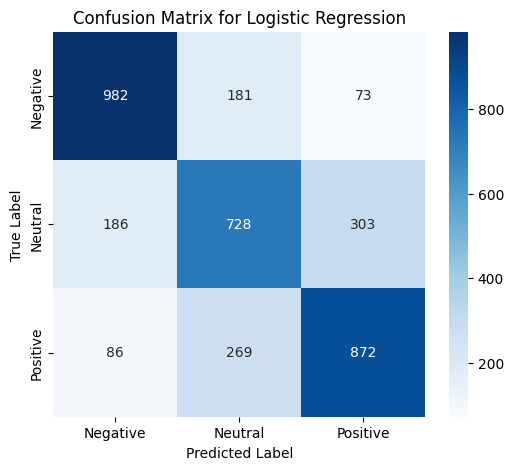

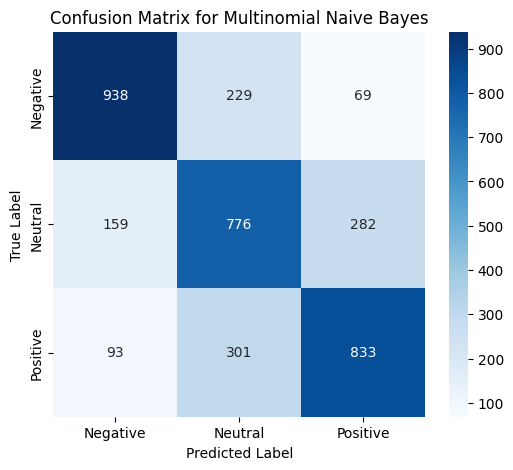

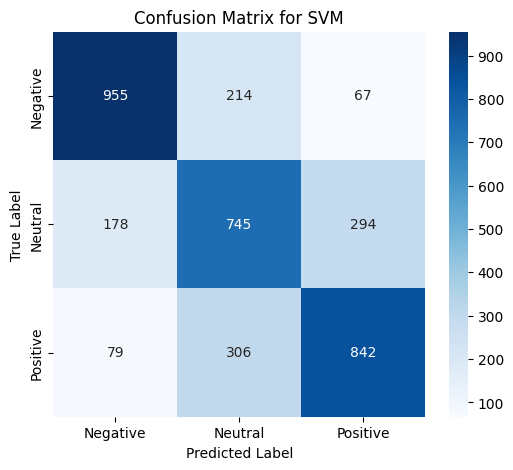

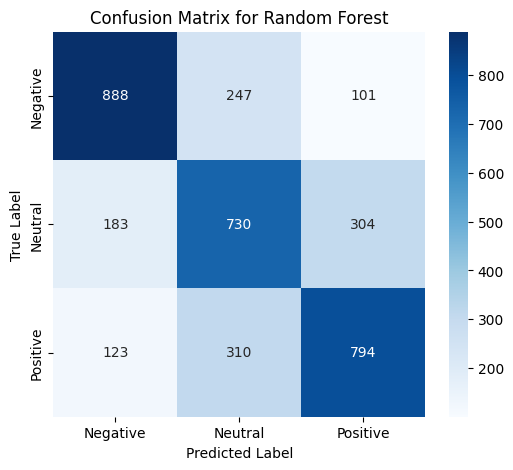

In [8]:
models = {
    "Logistic Regression": (lr_model, y_pred_lr),
    "Multinomial Naive Bayes": (mnb_model, y_pred_mnb),
    "SVM": (svm_model, y_pred_svm),
    "Random Forest": (rf_model, y_pred_rf)
}

for name, (model, y_pred) in models.items():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### ROC Curves Visualization

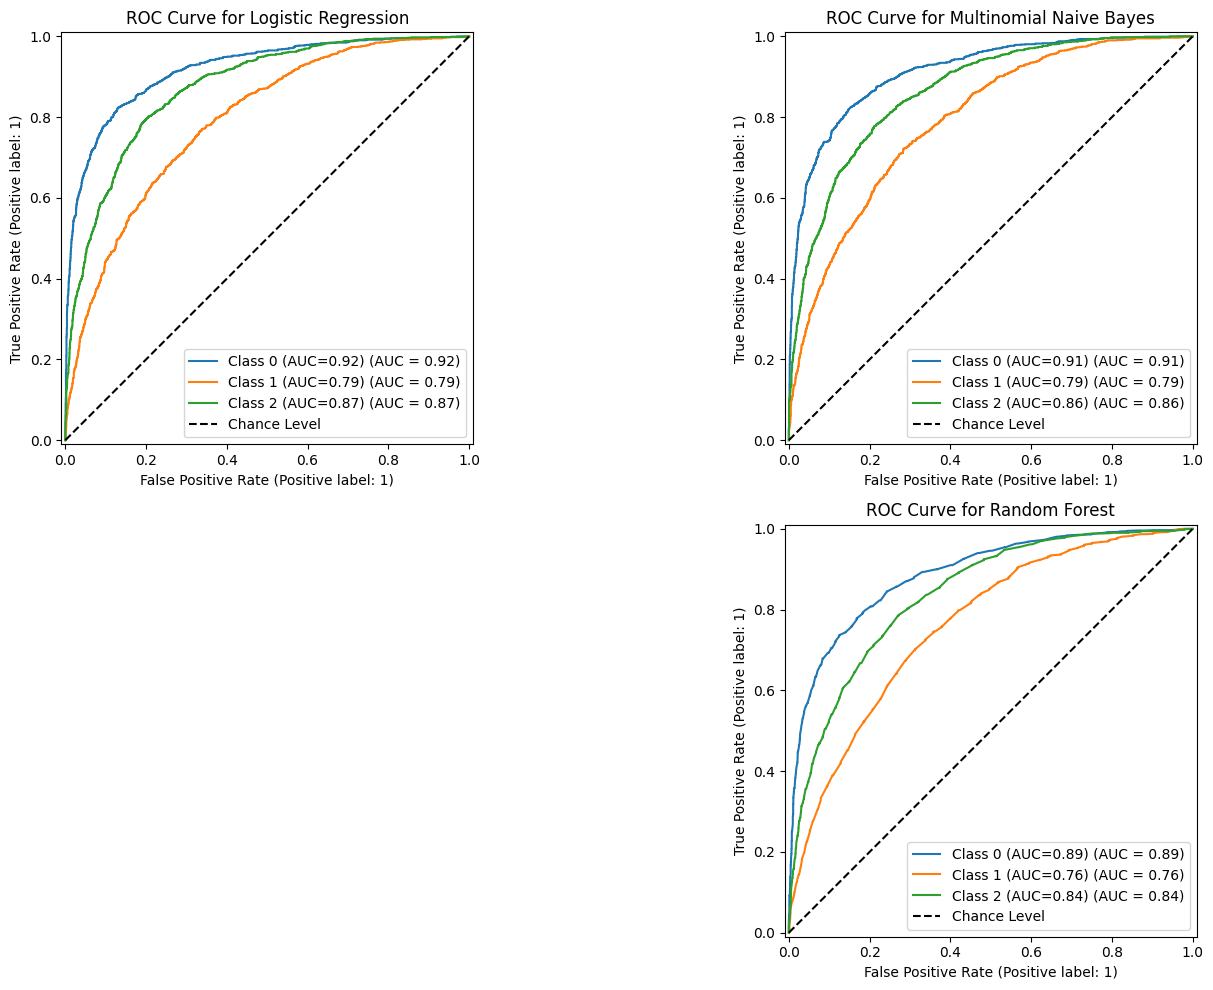

In [9]:
lb = LabelBinarizer()
# y_test_binarized will have columns for each class (0, 1, 2)
y_test_binarized = lb.fit_transform(y_test)


plt.figure(figsize=(15, 10))

# --- Logistic Regression ROC ---
plt.subplot(2, 2, 1)
y_score_lr = lr_model.predict_proba(X_test_tfidf)
RocCurveDisplay.from_predictions(y_test_binarized[:, 0], y_score_lr[:, 0], name=f'Class 0 (AUC={auc(roc_curve(y_test_binarized[:, 0], y_score_lr[:, 0])[0], roc_curve(y_test_binarized[:, 0], y_score_lr[:, 0])[1]):.2f})', pos_label=1, ax=plt.gca())
RocCurveDisplay.from_predictions(y_test_binarized[:, 1], y_score_lr[:, 1], name=f'Class 1 (AUC={auc(roc_curve(y_test_binarized[:, 1], y_score_lr[:, 1])[0], roc_curve(y_test_binarized[:, 1], y_score_lr[:, 1])[1]):.2f})', pos_label=1, ax=plt.gca())
RocCurveDisplay.from_predictions(y_test_binarized[:, 2], y_score_lr[:, 2], name=f'Class 2 (AUC={auc(roc_curve(y_test_binarized[:, 2], y_score_lr[:, 2])[0], roc_curve(y_test_binarized[:, 2], y_score_lr[:, 2])[1]):.2f})', pos_label=1, ax=plt.gca())
plt.title('ROC Curve for Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
plt.legend()


# --- Multinomial Naive Bayes ROC ---
plt.subplot(2, 2, 2)
y_score_mnb = mnb_model.predict_proba(X_test_tfidf)
RocCurveDisplay.from_predictions(y_test_binarized[:, 0], y_score_mnb[:, 0], name=f'Class 0 (AUC={auc(roc_curve(y_test_binarized[:, 0], y_score_mnb[:, 0])[0], roc_curve(y_test_binarized[:, 0], y_score_mnb[:, 0])[1]):.2f})', pos_label=1, ax=plt.gca())
RocCurveDisplay.from_predictions(y_test_binarized[:, 1], y_score_mnb[:, 1], name=f'Class 1 (AUC={auc(roc_curve(y_test_binarized[:, 1], y_score_mnb[:, 1])[0], roc_curve(y_test_binarized[:, 1], y_score_mnb[:, 1])[1]):.2f})', pos_label=1, ax=plt.gca())
RocCurveDisplay.from_predictions(y_test_binarized[:, 2], y_score_mnb[:, 2], name=f'Class 2 (AUC={auc(roc_curve(y_test_binarized[:, 2], y_score_mnb[:, 2])[0], roc_curve(y_test_binarized[:, 2], y_score_mnb[:, 2])[1]):.2f})', pos_label=1, ax=plt.gca())
plt.title('ROC Curve for Multinomial Naive Bayes')
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
plt.legend()


# --- SVM (SVC) ROC (Requires probability=True during SVC initialization to get predict_proba) ---
# As SVM was initialized without probability=True, we can't directly use predict_proba.
# If you need ROC for SVM, you would need to re-initialize and retrain it with probability=True.
# For now, we will skip SVM ROC or provide a placeholder.
# If probability=True was set, the code would look like this:
# plt.subplot(2, 2, 3)
# y_score_svm = svm_model.predict_proba(X_test_tfidf)
# RocCurveDisplay.from_predictions(y_test_binarized[:, 0], y_score_svm[:, 0], name=f'Class 0 (AUC={auc(roc_curve(y_test_binarized[:, 0], y_score_svm[:, 0])[0], roc_curve(y_test_binarized[:, 0], y_score_svm[:, 0])[1]):.2f})', pos_label=1, ax=plt.gca())
# ... and so on for other classes
# plt.title('ROC Curve for SVM')
# plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
# plt.legend()


# --- Random Forest ROC ---
plt.subplot(2, 2, 4)
y_score_rf = rf_model.predict_proba(X_test_tfidf)
RocCurveDisplay.from_predictions(y_test_binarized[:, 0], y_score_rf[:, 0], name=f'Class 0 (AUC={auc(roc_curve(y_test_binarized[:, 0], y_score_rf[:, 0])[0], roc_curve(y_test_binarized[:, 0], y_score_rf[:, 0])[1]):.2f})', pos_label=1, ax=plt.gca())
RocCurveDisplay.from_predictions(y_test_binarized[:, 1], y_score_rf[:, 1], name=f'Class 1 (AUC={auc(roc_curve(y_test_binarized[:, 1], y_score_rf[:, 1])[0], roc_curve(y_test_binarized[:, 1], y_score_rf[:, 1])[1]):.2f})', pos_label=1, ax=plt.gca())
RocCurveDisplay.from_predictions(y_test_binarized[:, 2], y_score_rf[:, 2], name=f'Class 2 (AUC={auc(roc_curve(y_test_binarized[:, 2], y_score_rf[:, 2])[0], roc_curve(y_test_binarized[:, 2], y_score_rf[:, 2])[1]):.2f})', pos_label=1, ax=plt.gca())
plt.title('ROC Curve for Random Forest')
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
plt.legend()

plt.tight_layout()
plt.show()